# Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
#setting working directory
os.chdir('F:/Deep Learning Projects')

In [3]:
#defining the required params
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 30

# Reading the data

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'pepper_bell_disease', 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2475 files belonging to 2 classes.


In [5]:
#class names of the dataset
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [6]:
#length of the dataset
len(dataset)

39

# Defining function for train, validation and test split

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
#train validation test split
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

31
3
5


# Cache and prefetch

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resize and Rescale

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
#applying data augmentation to the training set
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Defining the model

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
#fitting the model with training data
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
31/31 [==============================] - 160s 5s/step - loss: 0.6203 - accuracy: 0.6855 - val_loss: 0.5840 - val_accuracy: 0.6250
Epoch 2/30
31/31 [==============================] - 136s 4s/step - loss: 0.3640 - accuracy: 0.8564 - val_loss: 0.1543 - val_accuracy: 0.9531
Epoch 3/30
31/31 [==============================] - 135s 4s/step - loss: 0.2949 - accuracy: 0.9088 - val_loss: 0.6642 - val_accuracy: 0.8177
Epoch 4/30
31/31 [==============================] - 133s 4s/step - loss: 0.1465 - accuracy: 0.9506 - val_loss: 0.2639 - val_accuracy: 0.8698
Epoch 5/30
31/31 [==============================] - 134s 4s/step - loss: 0.0832 - accuracy: 0.9718 - val_loss: 0.0530 - val_accuracy: 0.9792
Epoch 6/30
31/31 [==============================] - 133s 4s/step - loss: 0.0511 - accuracy: 0.9819 - val_loss: 0.0482 - val_accuracy: 0.9792
Epoch 7/30
31/31 [==============================] - 133s 4s/step - loss: 0.0608 - accuracy: 0.9798 - val_loss: 0.0111 - val_accuracy: 0.9948
Epoch 8/30
31

In [18]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 9s 1s/step - loss: 0.0419 - accuracy: 0.9781


In [19]:
scores

[0.04194570332765579, 0.9781249761581421]

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Ploting using matplotlib

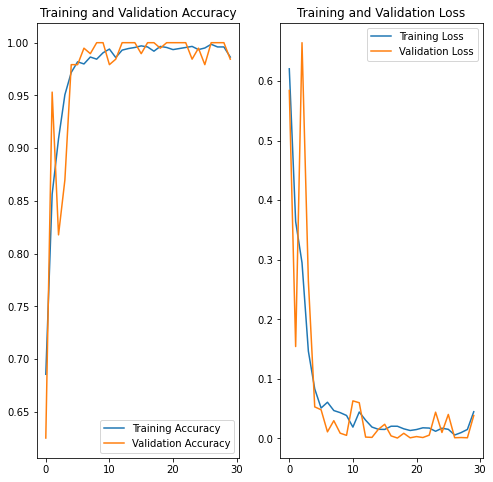

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___healthy
2/2 [==============================] - 3s 491ms/step
predicted label: Pepper__bell___healthy


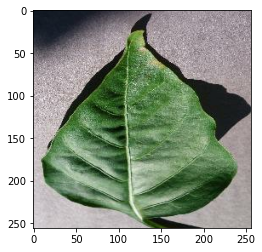

In [22]:
#predict the class of the first image
class_names = dataset.class_names

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 57ms/step


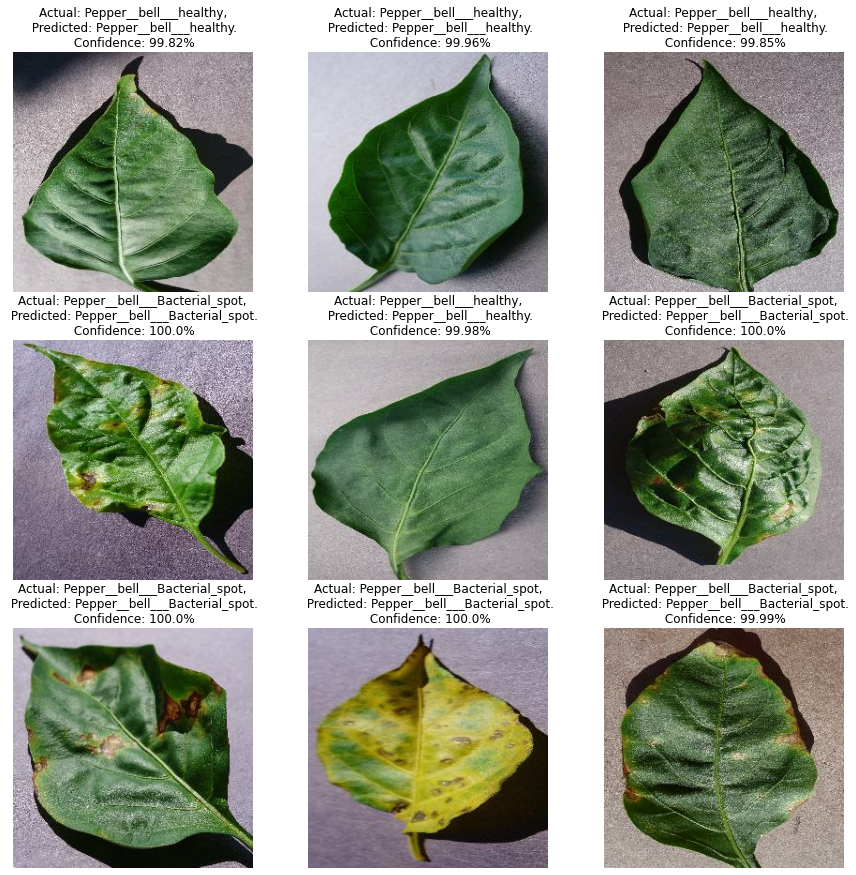

In [24]:
#predicting first 9 images using predict function defined above
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [25]:
#saving the model 
model_version = 1
model.save(f'F:/Deep Learning Projects/pepper_bell_disease/models/{model_version}')

INFO:tensorflow:Assets written to: F:/Deep Learning Projects/pepper_bell_disease/models/1\assets


INFO:tensorflow:Assets written to: F:/Deep Learning Projects/pepper_bell_disease/models/1\assets


# Resources

In [ ]:
#https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
#https://www.youtube.com/watch?v=zfiSAzpy9NM
#https://www.youtube.com/watch?v=MLEKEplgCas&t=438s
#https://www.kaggle.com/code/ownit4137/plant-disease-classification-using-efficientnet/data

#FastAPI: https://www.youtube.com/watch?v=Wr1JjhTt1Xg
